In [1]:
import math
import os
import re
from copy import deepcopy
from pathlib import Path
from typing import Union

import numpy as np
import scipy.constants
from scipy.constants import physical_constants

import cheetah

In [2]:
os.environ["LCLS_LATTICE"] = str((Path(".").absolute().parent / "lcls-lattice"))
os.environ["LCLS_LATTICE"]

'/Users/jankaiser/Documents/DESY/lcls-lattice'

In [3]:
lattice_file_path = (
    Path("$LCLS_LATTICE") / "bmad" / "models" / "cu_hxr" / "cu_hxr.lat.bmad"
)
lattice_file_path

PosixPath('$LCLS_LATTICE/bmad/models/cu_hxr/cu_hxr.lat.bmad')

In [4]:
resolved_lattice_file_path = Path(
    *[
        os.environ[part[1:]] if part.startswith("$") else part
        for part in lattice_file_path.parts
    ]
)
resolved_lattice_file_path

PosixPath('/Users/jankaiser/Documents/DESY/lcls-lattice/bmad/models/cu_hxr/cu_hxr.lat.bmad')

In [5]:
lines = cheetah.dontbmad.read_clean_lines(resolved_lattice_file_path)
lines[:20]

['beginning[beta_a] =  5.91253676811640894e+000',
 'beginning[alpha_a] =  3.55631307633660354e+000',
 'beginning[beta_b] =  5.91253676811640982e+000',
 'beginning[alpha_b] =  3.55631307633660398e+000',
 'beginning[e_tot] = 6e6',
 'parameter[geometry] = open',
 'parameter[particle] = electron',
 'beginning[theta_position] = -35*pi/180',
 'beginning[z_position] = 3050.512000 - 1032.60052',
 'beginning[x_position] = 10.44893',
 'setsp = 0',
 'setcus = 0',
 'setal = 0',
 'setda = 0',
 'setxleap2 = 0',
 'sethxrss = 0',
 'setsxrss = 0',
 'setcbxfel = 0',
 'setpepx = 0',
 'intgsx = 30.0']

In [6]:
merged_lines = cheetah.dontbmad.merge_delimiter_continued_lines(
    lines, delimiter="&", remove_delimiter=True
)
merged_lines = cheetah.dontbmad.merge_delimiter_continued_lines(
    merged_lines, delimiter=",", remove_delimiter=False
)
merged_lines = cheetah.dontbmad.merge_delimiter_continued_lines(
    merged_lines, delimiter="{", remove_delimiter=False
)
len(lines), len(merged_lines)

(14409, 12215)

In [7]:
context = cheetah.dontbmad.parse_lines(merged_lines)

In [8]:
def validate_understood_properties(understood: list[str], properties: dict) -> None:
    """
    Validate that all properties are understood. This function primarily ensures that
    properties not understood by Cheetah are not ignored silently.
    """
    for property in properties:
        assert property in understood, (
            f"Property {property} with value {properties[property]} for element type"
            f" {properties['element_type']} is currently not understood. Other values"
            f" in properties are {properties.keys()}."
        )

In [9]:
def convert_element(name: str, context: dict) -> cheetah.Element:
    """Convert a parsed Bmad element dict to a cheetah Element."""
    bmad_parsed = context[name]

    if isinstance(bmad_parsed, list):
        return cheetah.Segment(
            cell=[
                convert_element(element_name, context) for element_name in bmad_parsed
            ],
            name=name,
        )
    elif isinstance(bmad_parsed, dict) and "element_type" in bmad_parsed:
        if bmad_parsed["element_type"] == "marker":
            validate_understood_properties(
                [
                    "element_type",
                    "alias",
                    "type",
                    "sr_wake",
                    r"sr_wake%scale_with_length",
                    r"sr_wake%amp_scale",
                ],
                bmad_parsed,
            )
            return cheetah.Marker(name=name)
        elif bmad_parsed["element_type"] == "monitor":
            validate_understood_properties(
                ["element_type", "alias", "type", "l"], bmad_parsed
            )
            if "l" in bmad_parsed:
                return cheetah.Drift(length=bmad_parsed["l"], name=name)
            else:
                return cheetah.Marker(name=name)
        elif bmad_parsed["element_type"] == "instrument":
            validate_understood_properties(
                ["element_type", "alias", "type", "l"], bmad_parsed
            )
            if "l" in bmad_parsed:
                return cheetah.Drift(length=bmad_parsed["l"], name=name)
            else:
                return cheetah.Marker(name=name)
        elif bmad_parsed["element_type"] == "pipe":
            validate_understood_properties(
                ["element_type", "alias", "type", "l", "descrip"], bmad_parsed
            )
            return cheetah.Drift(length=bmad_parsed["l"], name=name)
        elif bmad_parsed["element_type"] == "drift":
            validate_understood_properties(
                ["element_type", "l", "type", "descrip"], bmad_parsed
            )
            return cheetah.Drift(length=bmad_parsed["l"], name=name)
        elif bmad_parsed["element_type"] == "hkicker":
            validate_understood_properties(
                ["element_type", "type", "alias"], bmad_parsed
            )
            return cheetah.HorizontalCorrector(
                length=bmad_parsed["l"] if "l" in bmad_parsed else 0.0,
                angle=bmad_parsed["kick"] if "kick" in bmad_parsed else 0.0,
                name=name,
            )
        elif bmad_parsed["element_type"] == "vkicker":
            validate_understood_properties(
                ["element_type", "type", "alias"], bmad_parsed
            )
            return cheetah.VerticalCorrector(
                length=bmad_parsed["l"] if "l" in bmad_parsed else 0.0,
                angle=bmad_parsed["kick"] if "kick" in bmad_parsed else 0.0,
                name=name,
            )
        elif bmad_parsed["element_type"] == "quadrupole":
            # TODO: Aperture for quadrupoles?
            validate_understood_properties(
                ["element_type", "l", "k1", "type", "aperture", "alias", "tilt"],
                bmad_parsed,
            )
            return cheetah.Quadrupole(
                length=bmad_parsed["l"],
                k1=bmad_parsed["k1"],
                tilt=bmad_parsed["tilt"] if "tilt" in bmad_parsed else 0.0,
                name=name,
            )
        elif bmad_parsed["element_type"] == "solenoid":
            validate_understood_properties(
                ["element_type", "l", "ks", "alias"], bmad_parsed
            )
            return cheetah.Solenoid(
                length=bmad_parsed["l"], k=bmad_parsed["ks"], name=name
            )
        elif bmad_parsed["element_type"] == "lcavity":
            validate_understood_properties(
                [
                    "element_type",
                    "l",
                    "type",
                    "frequency",
                    "voltage",
                    "phi0",
                    "sr_wake",
                    "cavity_type",
                    "alias",
                ],
                bmad_parsed,
            )
            return cheetah.Cavity(length=bmad_parsed["l"], name=name)
        elif bmad_parsed["element_type"] == "rcollimator":
            validate_understood_properties(
                ["element_type", "l", "alias", "type"], bmad_parsed
            )
            return cheetah.Aperture(
                x_max=np.inf, y_max=np.inf, shape="rectangular", name=name
            )
        elif bmad_parsed["element_type"] == "ecollimator":
            print(f"ecollimator {name}")
            validate_understood_properties(
                ["element_type", "l", "alias", "type"], bmad_parsed
            )
            return cheetah.Aperture(
                x_max=np.inf, y_max=np.inf, shape="elliptical", name=name
            )
        else:
            print(
                f"WARNING: Element {name} of type {bmad_parsed['element_type']} cannot"
                " be converted correctly. Using drift section instead."
            )
            # TODO: Remove the length if by adding markers to Cheeath
            return cheetah.Drift(
                name=name, length=bmad_parsed["l"] if "l" in bmad_parsed else 0.0
            )
    else:
        raise ValueError(f"Unknown Bmad element type for {name = }")

In [10]:
segment = convert_element(context["__use__"], context)
segment

ecollimator pcapm1


AssertionError: Property limit with value 0.00635 for element type ecollimator is currently not understood. Other values in properties are dict_keys(['element_type', 'type', 'l', 'limit', 'alias']).

In [ ]:
segment

Segment([Segment([Segment([Drift(length=-0.87, name="dl00"), Drift(length=0.87, name="loadlock"), Marker(is_active=False, is_skippable=True, name='beggun', device='cpu', length=0), Solenoid(length=0.00, k=0.00, name="sol1bk"), Marker(is_active=False, is_skippable=True, name='dbmark80', device='cpu', length=0), Marker(is_active=False, is_skippable=True, name='cathode', device='cpu', length=0), Drift(length=0.10, name="dl01a"), Segment([Solenoid(length=0.20, k=0.00, name="sol1")]), Drift(length=0.08, name="dl01a1"), Marker(is_active=False, is_skippable=True, name='vv01', device='cpu', length=0), Drift(length=0.12, name="dl01a2"), Marker(is_active=False, is_skippable=True, name='am00', device='cpu', length=0), Drift(length=0.10, name="dl01a3"), Marker(is_active=False, is_skippable=True, name='am01', device='cpu', length=0), Drift(length=0.02, name="dl01a4"), Marker(is_active=False, is_skippable=True, name='yag01', device='cpu', length=0), Drift(length=0.01, name="dl01a5"), Marker(is_activ

In [ ]:
segment.flattened()

Segment([Drift(length=-0.87, name="dl00"), Drift(length=0.87, name="loadlock"), Marker(is_active=False, is_skippable=True, name='beggun', device='cpu', length=0), Solenoid(length=0.00, k=0.00, name="sol1bk"), Marker(is_active=False, is_skippable=True, name='dbmark80', device='cpu', length=0), Marker(is_active=False, is_skippable=True, name='cathode', device='cpu', length=0), Drift(length=0.10, name="dl01a"), Solenoid(length=0.20, k=0.00, name="sol1"), Drift(length=0.08, name="dl01a1"), Marker(is_active=False, is_skippable=True, name='vv01', device='cpu', length=0), Drift(length=0.12, name="dl01a2"), Marker(is_active=False, is_skippable=True, name='am00', device='cpu', length=0), Drift(length=0.10, name="dl01a3"), Marker(is_active=False, is_skippable=True, name='am01', device='cpu', length=0), Drift(length=0.02, name="dl01a4"), Marker(is_active=False, is_skippable=True, name='yag01', device='cpu', length=0), Drift(length=0.01, name="dl01a5"), Marker(is_active=False, is_skippable=True, n

NotImplementedError: 

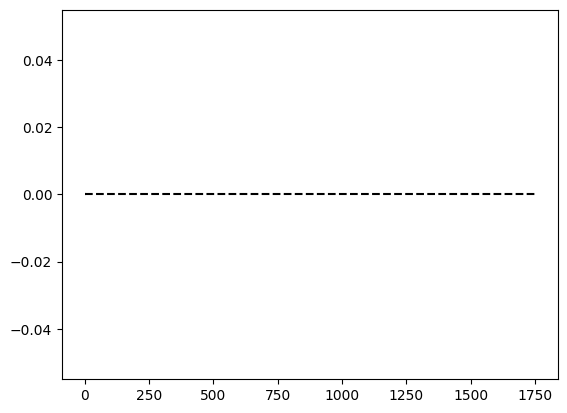

In [ ]:
import matplotlib.pyplot as plt

segment.plot(ax=plt.gca(), s=0.0)